In [1]:
import numpy as np
from numpy.linalg import matrix_rank
import random as ran
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from itertools import combinations
from sympy import *

This code computes the betti-numbers for an n-dimensional data set
It finds the rank of the persistent homology groups. This roughly means that it reveals how 'connected' and 'hole-ey' a data set is.

Much of this code is adapted from an end-of-undergraduate-degree project I completed in 2023. While the code was written largely independently, I have Prof. Anca Mustata to thank for her unwavering guidance and support.

In [2]:
def norm(p,q):
    while len(p) < len(q):
        p.append(0)
    while len(q) < len(p):
        q.append(0)
     
    sum = 0
    for i in range(len(p)):
        sum += (p[i]-q[i])**2
        
    return sum**(1/2)

# First compute the simplicial complex of collections of k points
# To Implement: Option to present S in coordinate form or regular form
def S(data, eps, k, coord=True):
    
    SIMP = []
    
    coord_to_index = {}
    for p in data:
        coord_to_index[str(p)] = data.index(p)
    
    for p in data:
        # Creates a set of points within range of p
        neighbours = []
        for q in data:
            if q != p:
                if norm(p,q) < eps:
                    neighbours.append(q)
                    # [[a,b],[c,d],[e,f],...]
                
        # Creates a list of groups that could potentially form a point in the simplicial complex S
        # Only consider k-1 points at a time since we are ignoring p for now
        candidates = list(combinations(neighbours, k-1))
        # [([a,b],[c,d],[e,f],...), ([a,b],[e,f],...), (...), ...]
        
        if k > 2:
        
            for group in candidates:

                # group = ([a,b],[c,d],...)
                group = list(group)
                # group = [[a,b],[c,d],...]

                # Iterates though all pairs in a group
                pairings = list(combinations(group,2))
                # pairings = [([a,b],[c,d]), (...), ...]

                for pair in pairings:
                    pair = list(pair)

                if all(norm(pair[0],pair[1]) < eps for pair in pairings):
                    group.append(p)
                    SIMP.append(sorted(group))
                    
        elif k == 2:
            for q in neighbours:
                SIMP.append(sorted([p,q]))
                
        elif k == 1:
            SIMP.append(p)  
            
    # Seeking to generalise this to n-dimensions

    if coord == False:
        if k == 1:
            for index,my_list in enumerate(SIMP):
                SIMP[index] = [coord_to_index[str(my_list)]]
        else:
            for index,my_list in enumerate(SIMP):
                SIMP[index] = [coord_to_index[str(d)] for d in my_list]
    
    '''if coord==False:
        if k == 1:
            SIMP = [[coord_to_index[str(d)]] for d in SIMP]
        if k == 2:
            SIMP = [[coord_to_index[str(d)], coord_to_index[str(e)]] for [d,e] in SIMP]
        if k == 3:
            SIMP = [[coord_to_index[str(d)], coord_to_index[str(e)], coord_to_index[str(f)]] for [d,e,f] in SIMP]'''
                

    SIMP = sorted(SIMP)   
    for l in SIMP:
        if SIMP.count(l) > 1:
            SIMP.remove(l)
                
    return SIMP

In [4]:
def del_k(L,k):

    faces = [p for p in L if len(p) == k+1]

    if k == 0:
        array = [0 for f in faces]
        return Matrix(array).T

    if len(faces) == 0:
        return Matrix([0])

    edges = [p for p in L if len(p) == k]

    # iterate through faces for each edge
    array = []
    for edge in edges:
        row = []
        for face in faces:
            flag = 0
            for index, point in enumerate(face):
                face_remove = [p for p in face if p != point]
                if face_remove == edge:
                    if index % 2 == 0:
                        row.append(1)
                    if index % 2 == 1:
                        row.append(-1)
                    flag = 1
            if flag == 0:
                row.append(0)
        array.append(row)


    matrix = Matrix(array)
    return matrix

In [5]:
#Functions sourced directly from https://eric-bunch.github.io/blog/calculating_homology_of_simplicial_complex
#===================

def leftmult2(m, i0, i1, a, b, c, d):
    for j in range(m.cols):
        x, y = m[i0, j], m[i1, j]
        m[i0, j] = a * x + b * y
        m[i1, j] = c * x + d * y

def rightmult2(m, j0, j1, a, b, c, d):
    for i in range(m.rows):
        x, y = m[i, j0], m[i, j1]
        m[i, j0] = a * x + c * y
        m[i, j1] = b * x + d * y

def smith(m, domain=ZZ):
    try:
        m = Matrix(m)
        s = eye(m.rows)
        t = eye(m.cols)

        last_j = -1
        for i in range(m.rows):
            for j in range(last_j+1, m.cols):
                if not m.col(j).is_zero:
                    break
            else:
                break
            if m[i,j] == 0:
                for ii in range(m.rows):
                    if m[ii,j] != 0:
                        break
                leftmult2(m, i, ii, 0, 1, 1, 0)
                rightmult2(s, i, ii, 0, 1, 1, 0)
            rightmult2(m, j, i, 0, 1, 1, 0)
            leftmult2(t, j, i, 0, 1, 1, 0)
            j = i
            upd = True
            while upd:
                upd = False
                for ii in range(i+1, m.rows):
                    if m[ii, j] == 0:
                        continue
                    upd = True
                    if domain.rem(m[ii, j], m[i, j]) != 0:
                        coef1, coef2, g = domain.gcdex(m[i,j], m[ii, j])
                        coef3 = domain.quo(m[ii, j], g)
                        coef4 = domain.quo(m[i, j], g)
                        leftmult2(m, i, ii, coef1, coef2, -coef3, coef4)
                        rightmult2(s, i, ii, coef4, -coef2, coef3, coef1)
                    coef5 = domain.quo(m[ii, j], m[i, j])
                    leftmult2(m, i, ii, 1, 0, -coef5, 1)
                    rightmult2(s, i, ii, 1, 0, coef5, 1)
                for jj in range(j+1, m.cols):
                    if m[i, jj] == 0:
                        continue
                    upd = True
                    if domain.rem(m[i, jj], m[i, j]) != 0:
                        coef1, coef2, g = domain.gcdex(m[i,j], m[i, jj])
                        coef3 = domain.quo(m[i, jj], g)
                        coef4 = domain.quo(m[i, j], g)
                        rightmult2(m, j, jj, coef1, -coef3, coef2, coef4)
                        leftmult2(t, j, jj, coef4, coef3, -coef2, coef1)
                    coef5 = domain.quo(m[i, jj], m[i, j])
                    rightmult2(m, j, jj, 1, -coef5, 0, 1)
                    leftmult2(t, j, jj, 1, coef5, 0, 1)
            last_j = j
        for i1 in range(min(m.rows, m.cols)):
            for i0 in reversed(range(i1)):
                coef1, coef2, g = domain.gcdex(m[i0, i0], m[i1,i1])
                if g == 0:
                    continue
                coef3 = domain.quo(m[i1, i1], g)
                coef4 = domain.quo(m[i0, i0], g)
                leftmult2(m, i0, i1, 1, coef2, coef3, coef2*coef3-1)
                rightmult2(s, i0, i1, 1-coef2*coef3, coef2, coef3, -1)
                rightmult2(m, i0, i1, coef1, 1-coef1*coef4, 1, -coef4)
                leftmult2(t, i0, i1, coef4, 1-coef1*coef4, 1, -coef1)
        return (s, m, t, 0)
    except (ValueError, ZeroDivisionError):
        return (0, m, 0, 1)
#===================

In [6]:
'''
The rank of an integer matrix A can be determined by finding the smith form of A = QDP, and finding the rank of D.
The rank of D can be determined by counting the number of non-zero elements along the diagonal 
'''
def smith_rank(A):

    S = smith(A)

    # if smith works
    if S[3] == 0:
        D = S[1]

        rows = shape(D)[0]
        cols = shape(D)[1]

        rank = 0
        for i in range(min([rows,cols])):
            if (D.row(i)).col(i) != Matrix([[0]]):
                rank = rank + 1

        return rank

    # if it doesnt
    else:
        m = np.array(A).astype(np.float64)
        rank = matrix_rank(m)
        return rank

In [7]:
# obtains the betti number for the kth homology group
def Betti_Number(L,k):

    delk = del_k(L,k)
    delk1 = del_k(L,k+1) 

    m = shape(delk)[1]

    s = smith_rank(delk)
    r = smith_rank(delk1)

    return m - r - s


def Simp_Set(eps, data, Kappa, coord=True):
    The_S = []

    for i in range(1,Kappa+2):
        my_S = S(data,eps,i,coord)

        The_S += my_S

    return The_S


def Betti_Set(eps,data, Kappa):

    # Kappa is the number of betti-numbers to be computed
    # The 0th betti-number marks the number of connected components, which needs 2-simplexes to compute
    # The 1st betti-number marks the number of 'holes', which needs 3-simplexes to compute
    # Hence Kappa+2 is used below

    The_S = []

    for i in range(1,Kappa+2):
        my_S = S(data,eps,i,coord=False)

        The_S += my_S

    B = [Betti_Number(The_S, j) for j in range(Kappa)]
    
    return B

Let's test the code on a sample dataset. We will construct a 'noisy circle' and premptively visualise the data.

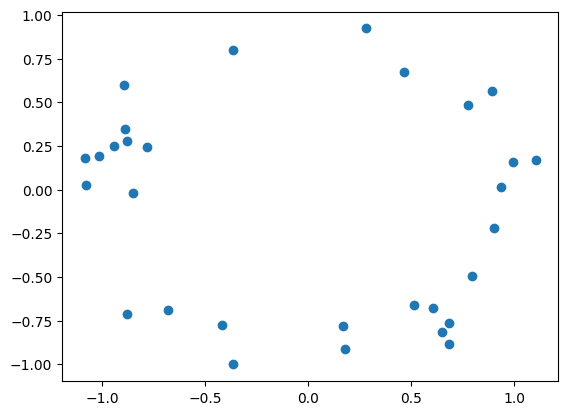

In [24]:
# Generate noisy circle of data
# use polar coords. r_avg = 1
# 0.8 < r < 1.2
# 0 < t < 2pi
# ran.random() returns a random value between 0 and 1

a = 0.8
b = 0.4

def noisy_circle(R, n):
    data = []
    for i in range(n):
        r = R*(a + b*ran.random()) # returns random r between a*R and (a+b)*R
        t = 2*np.pi*ran.random()   # returns random t between 0 and 2*pi
        p = [r*np.cos(t), r*np.sin(t)]
        
        data.append(p)
    
    return data

data = noisy_circle(1,30)

(X,Y) = ([x for [x,y] in data],[y for [x,y] in data])
plt.plot(X,Y, 'o')

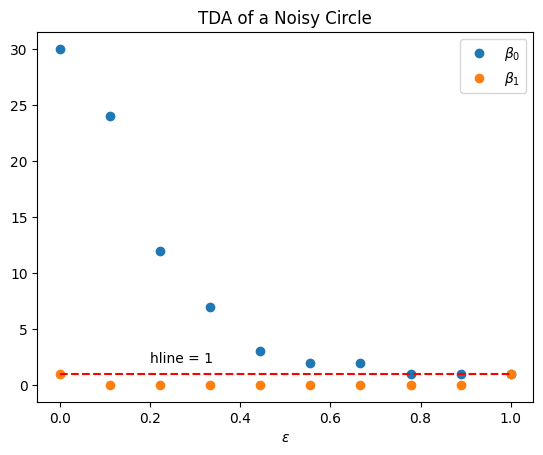

In [22]:


b0_data = []
b1_data = []
eps_space = np.linspace(0,1,10)
for eps in eps_space:
    D = Betti_Set(eps,data, 2)
    b0_data.append(D[0])
    b1_data.append(D[1])

plt.plot(eps_space,b0_data, 'o', label=r'$\beta_0$')
plt.plot(eps_space, b1_data, 'o', label=r'$\beta_1$')
plt.hlines(1, 0, 1, 'r', linestyles='dashed')
plt.text(0.2, 2, 'hline = 1')
plt.title('TDA of a Noisy Circle')
plt.xlabel(r'$\epsilon$')
plt.legend()
plt.show()

In the graph we can see large $\beta_0$ for small $\epsilon$, signifying a large number of isolated components. As $\epsilon$ increases, $\beta_0$ levels out to 1, which we expect since with larger $\epsilon$-neighbourhoods, previously disconnected components acquire the 'range' to link up, until the whole dataset integrates into a single shape. \n

Additionally, as $\epsilon$ increases, $\beta_1$ begins to stabilise around 1, signifying the prescence of a 2-dimensional hole. 